In [1]:
from datetime import datetime

import numpy as np
import pandas as pd

from cdt.metrics import SHD
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, Markdown

import lingam
print("lingam=", lingam.__version__)

np.random.seed(0)

def _make_dag(n_features=8):
    sign = np.random.choice([-1, 1], size=(n_features, n_features))
    coef = np.random.uniform(0.1, 0.9, size=(n_features, n_features))
    sparse = np.random.choice([0, 1], p=[0.3, 0.7], size=(n_features, n_features))

    graph = np.tril(sign * coef * sparse, k=-1)
    graph[np.isclose(graph, 0)] = 0
    
    G = nx.from_numpy_array(graph.T, create_using=nx.DiGraph)
    causal_order = list(nx.topological_sort(G))
    
    return graph, causal_order

def _make_tau_coefs(tau_len, n_features=8):
    coefs = []
    for i in range(tau_len):
        sign = np.random.choice([-1, 1], size=(n_features, n_features))
        coef = np.random.uniform(0.1, 0.9, size=(n_features, n_features))
        sparse = np.random.choice([0, 1], p=[0.5, 0.5], size=(n_features, n_features))

        coef = sign * coef * sparse
        coef[np.isclose(coef, 0)] = 0
        
        coefs.append(coef)
    return coefs

def make_data_set(obs_duration=10, n_lags=1, n_samples=1000, n_features=8):
    es = []
    causal_orders = []
    B = []
    X = []

    # initial data
    for tau in range(n_lags):
        X.append(np.zeros((n_features, n_samples)))

    # generate twice the data and use the second half of the data
    for t in range(len(X), obs_duration * 2):
        B_t, causal_order = _make_dag(n_features=n_features)
        B_taus = _make_tau_coefs(n_lags, n_features)

        e = np.random.uniform(0.1, 1.0, size=(n_features, n_samples))

        mix_mat = np.linalg.pinv(np.eye(n_features) - B_t)
        N_t = mix_mat @ e
        M_t = mix_mat @ np.hstack(B_taus)
        X_t = M_t @ np.vstack(X[t - n_lags:]) + N_t

        es.append(e.T)
        causal_orders.append(causal_order)
        B.append([B_t, *B_taus])
        X.append(X_t)

    causal_orders = causal_orders[-obs_duration:]
    B = np.array(B)[-obs_duration:]
    X = np.array(X)[-obs_duration:]
    X = np.transpose(X, [0, 2, 1])
    
    return X, B, causal_orders, es

def show_scatter(B_est, B_true):
    n_rows, n_cols = B_true.shape[:2]
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))
    for t, (true, est) in enumerate(zip(B_true, B_est)):
        for tau, (t_, e_) in enumerate(zip(true, est)):
            ax = axes[t, tau]
            ax.scatter(t_, e_)
            
            ax.axvline(0, color="black", lw=0.5, zorder=0)
            ax.axhline(0, color="black", lw=0.5, zorder=0)
            ax.axline((0, 0), slope=1, color="red", lw=0.5, zorder=0)

            ax.set_aspect("equal", "box")
            ax.set_box_aspect(1)
            ax.set_xlabel("true coefs")
            ax.set_ylabel("estimated coefs")
            ax.set_title(f"tau={tau}")
            
            if t == 0:
                ax.set_title(f"tau={tau}")
        axes[t, 0].set_ylabel(f"t={t}")
        
    plt.tight_layout()
    plt.show()

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


lingam= 1.9.1


## データ作成

In [2]:
n_lags = 2
n_features = 8
obs_duration = 10
display(Markdown(f"- n_lags={n_lags}\n- n_features={n_features}\n- obs_duration={obs_duration}"))

X, B, causal_orders, es = make_data_set(n_lags=n_lags, obs_duration=obs_duration, n_features=n_features)

if obs_duration < 5:
    for t, b in enumerate(B[:, 0]):
        display(Markdown(f"#### t={t}時点の即時関係"))
        display(lingam.utils.make_dot(b))

print("B.shape =", B.shape)

pd.DataFrame(np.hstack(np.hstack(B)))

- n_lags=2
- n_features=8
- obs_duration=10

B.shape = (10, 3, 8, 8)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,-0.774378,0.000000,0.745620,0.541121,0.162698,0.000000,0.885051,0.000000,0.000000,-0.417885
1,0.326177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.765996,0.382080,-0.598572,0.793575,0.000000,0.000000,0.000000,-0.853957
2,0.000000,0.326917,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.493623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.702411
3,-0.378710,0.000000,-0.624434,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.323734,...,0.000000,-0.269152,-0.327976,0.314049,0.191108,0.000000,0.147495,-0.235016,-0.584701,0.000000
4,0.698061,0.000000,-0.885812,-0.699839,0.000000,0.000000,0.000000,0.0,-0.589139,0.000000,...,0.807354,0.452349,0.100964,0.000000,0.000000,0.000000,-0.878666,0.000000,0.279767,0.576792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.828610,-0.620774,0.323124,0.000000,0.000000,0.000000,0.000000,0.0,0.758184,0.781098,...,0.000000,0.000000,0.000000,0.762684,-0.561924,0.000000,0.000000,0.307958,0.000000,0.000000
76,-0.542441,0.710273,0.374599,0.571578,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.850660,-0.148741,0.000000,0.000000,0.000000,-0.649968,-0.761621,0.208425,0.000000,0.000000
77,0.000000,0.690774,0.000000,0.000000,-0.357128,0.000000,0.000000,0.0,0.622864,-0.453389,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.591968,0.000000,0.154086,0.517681
78,0.394238,0.000000,-0.350000,0.712401,0.000000,0.234894,0.000000,0.0,0.000000,-0.727768,...,0.000000,0.000000,0.000000,0.609326,0.668070,0.000000,-0.682839,0.000000,0.000000,0.000000


## 実行

### 事前知識を与えない場合

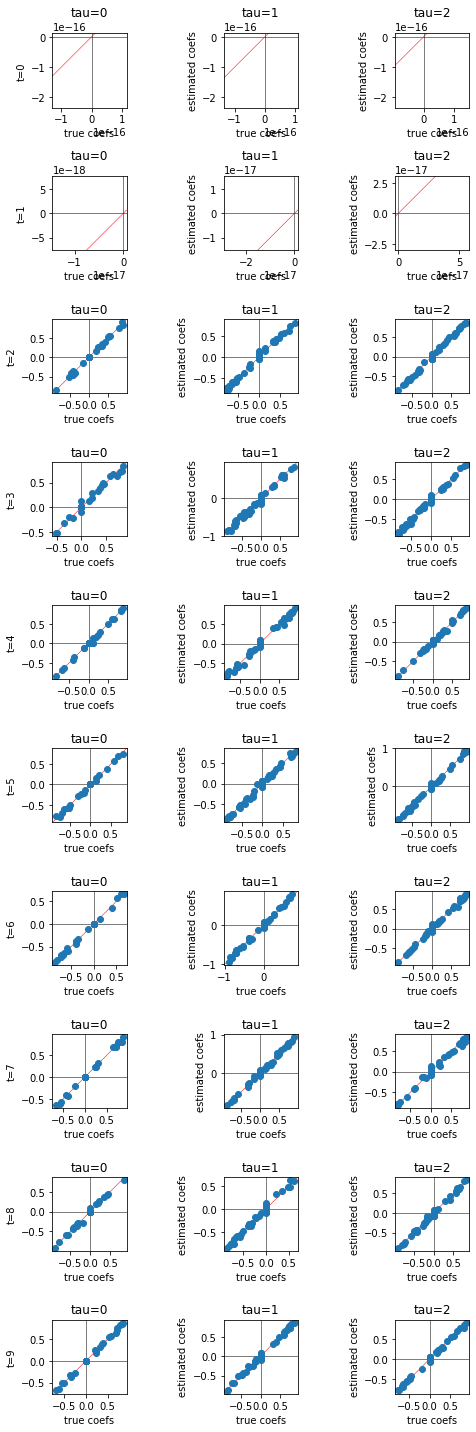

In [3]:
model = lingam.LongitudinalLiNGAM(n_lags=n_lags)
start = datetime.now()
model.fit(X)
elapse = (datetime.now() - start).total_seconds()
show_scatter(model.adjacency_matrices_, B)

### 事前知識を与える場合(ただしすべて-1)
事前知識の要素をすべて-1として与えると、パスの制限は行われず、推定の方法だけが変わるため、事前知識を与えない場合と同じ結果が得られることが期待される。

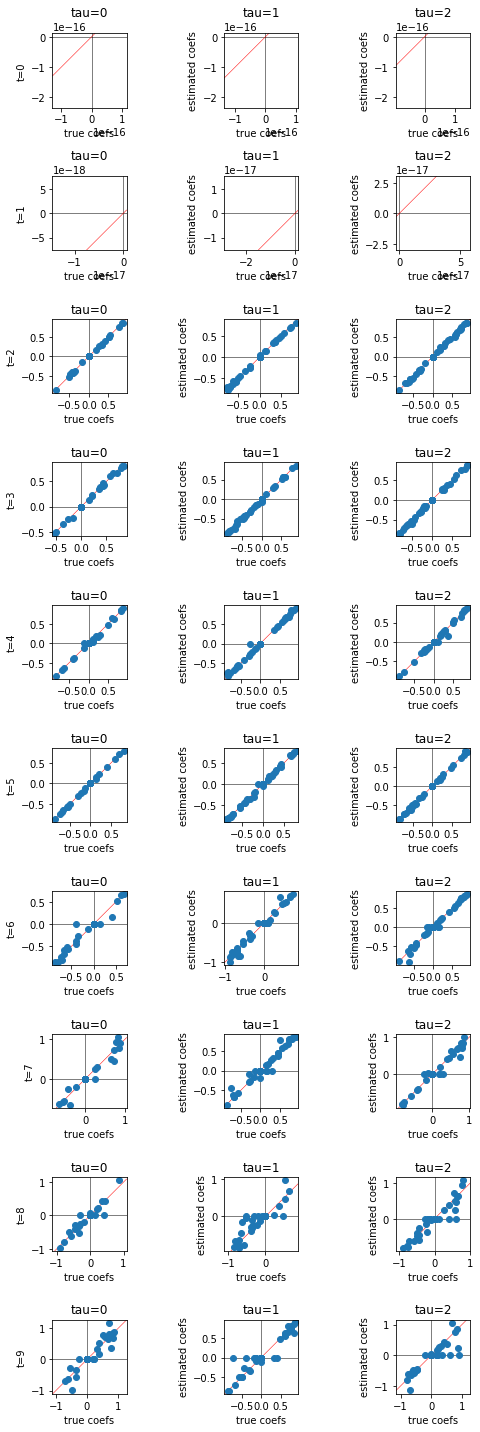

In [4]:
pk = np.ones((obs_duration, n_lags + 1, n_features, n_features)) * -1
model = lingam.LongitudinalLiNGAM(n_lags=n_lags, prior_knowledge=pk)
start = datetime.now()
model.fit(X)
elapse2 = (datetime.now() - start).total_seconds()
show_scatter(model.adjacency_matrices_, B)

事前知識を与える場合、ラグと観測期間をひとまとめにした巨大なグラフをDirectLiNGAMで推定することになる。そのため、実行に時間がかかったり、因果の下流では推定の精度が悪化(スパース推定の誤差も含めて)すると考えらえる。

事前知識なしの時の実行秒数と事前知識あり(すべて-1)の実行秒数は次の通り。精度は上の散布図の通り。t=4くらいからはずれる要素が出始めている。

In [5]:
elapse, elapse2

(0.5846, 4.974643)

## 実行速度と推定精度
観測期間を延ばすとどの程度の影響が出てくるか確認する。各観測期間の長さごとに5回ずつ実行した平均値をプロット。

In [6]:
n_lags = 2
n_features = 8

results = {}
for obs_duration in range(3, 14):
    adjs = []
    adjs_pk = []
    elapses = []
    elapses_pk = []
    
    for i in range(10):
        X, B, causal_orders, es = make_data_set(n_lags=n_lags, obs_duration=obs_duration, n_features=n_features)
        
        # 事前知識なし
        model = lingam.LongitudinalLiNGAM(n_lags=n_lags)
        start = datetime.now()
        model.fit(X)
        elapse = (datetime.now() - start).total_seconds()
        
        adjs.append((model.adjacency_matrices_, model.causal_orders_, B, causal_orders))
        elapses.append(elapse)
        
        # 事前知識あり
        pk = np.ones((obs_duration, n_lags + 1, n_features, n_features)) * -1
        model = lingam.LongitudinalLiNGAM(n_lags=n_lags, prior_knowledge=pk)
        start = datetime.now()
        model.fit(X)
        elapse_pk = (datetime.now() - start).total_seconds()
        
        adjs_pk.append((model.adjacency_matrices_, model.causal_orders_, B, causal_orders))
        elapses_pk.append(elapse_pk)
        
    results[obs_duration] = (adjs, adjs_pk, elapses, elapses_pk)

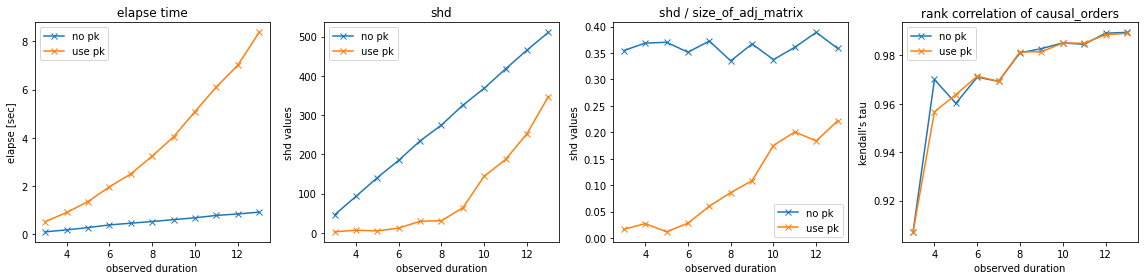

In [35]:
# elapses
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

x = results.keys()

# elapse
ax = axes[0]

y = np.array([elapses for (adjs, adjs_pk, elapses, elapses_pk) in results.values()])
y = np.mean(y, axis=1)
ax.plot(x, y, marker="x", label="no pk")

y = np.array([elapses_pk for (adjs, adjs_pk, elapses, elapses_pk) in results.values()])
y = np.mean(y, axis=1)
ax.plot(x, y, marker="x", label="use pk")

ax.legend()
ax.set_title("elapse time")
ax.set_xlabel("observed duration")
ax.set_ylabel("elapse [sec]")

# shd
ax = axes[1]

def evaluate(target, pred, std=False):
    t, lags, _, __ = target.shape
    
    value = 0
    for time in range(t):
        for tau in range(lags):
            v = SHD(
                (~np.isclose(target[time][tau], 0)).astype(int),
                (~np.isclose(pred[time][tau], 0)).astype(int),
                double_for_anticausal=False
            )
            value = value + v if not std else (v / (len(target[time][tau])**2))
    return value

y = []
for (adjs, adjs_pk, elapses, elapses_pk) in results.values():
    # n_lagsより前はnanのため除外
    y_ = [evaluate(true[n_lags:], est[n_lags:]) for est, _, true, __ in adjs]
    y.append(np.mean(y_))
ax.plot(x, y, marker="x", label="no pk")

y = []
for (adjs, adjs_pk, elapses, elapses_pk) in results.values():
    y_ = [evaluate(true[n_lags:], est[n_lags:]) for est, _, true, __ in adjs_pk]
    y.append(np.mean(y_))
ax.plot(x, y, marker="x", label="use pk")

ax.legend()
ax.set_title("shd")
ax.set_xlabel("observed duration")
ax.set_ylabel("shd values")

# shd / adj_size
ax = axes[2]

y = []
for (adjs, adjs_pk, elapses, elapses_pk) in results.values():
    # n_lagsより前はnanのため除外
    y_ = [evaluate(true[n_lags:], est[n_lags:], std=True) for est, _, true, __ in adjs]
    y.append(np.mean(y_))
ax.plot(x, y, marker="x", label="no pk")

y = []
for (adjs, adjs_pk, elapses, elapses_pk) in results.values():
    y_ = [evaluate(true[n_lags:], est[n_lags:], std=True) for est, _, true, __ in adjs_pk]
    y.append(np.mean(y_))
ax.plot(x, y, marker="x", label="use pk")

ax.legend()
ax.set_title("shd / size_of_adj_matrix")
ax.set_xlabel("observed duration")
ax.set_ylabel("shd values")

# kendall's tau (rank correlation of causal order)
ax = axes[3]

def evaluate2(target, pred):
    target = np.array([e + i * n_features for i, e in enumerate(np.array(target[n_lags:]))]).ravel()
    pred = np.array([e + i * n_features for i, e in enumerate(np.array(pred[n_lags:]))]).ravel()
    return kendalltau(target, pred).statistic

y = []
for (adjs, adjs_pk, elapses, elapses_pk) in results.values():
    y_ = [evaluate2(true, est) for _, est, __, true in adjs]
    y.append(np.mean(y_))
ax.plot(x, y, marker="x", label="no pk")

y = []
for (adjs, adjs_pk, elapses, elapses_pk) in results.values():
    y_ = [evaluate2(true, est) for _, est, __, true in adjs_pk]
    y.append(np.mean(y_))
ax.plot(x, y, marker="x", label="use pk")

ax.legend()
ax.set_title("rank correlation of causal_orders")
ax.set_xlabel("observed duration")
ax.set_ylabel("kendall's tau")

plt.tight_layout()
plt.show()

- shd
  - no pkはまっすぐ右上がり。観測期間が延びると単純に増えていく。
- rank correlationについて、因果の上流の誤りほど重いミスになるが考慮されていない。単純に各時刻の因果順序を一列のリストにして順位相関を計算している。
- 順位相関にはあまり違いがない。しかしshdはuse pkの方が精度がよい。
  - 時刻によるパスの制約を加えたDirectLiNGAMによって、一括でグラフを推定した方が精度がよいことになる。小分けにしてDirectLiNGAMするよりも精度がいいのかもしれない。